<a href="https://colab.research.google.com/github/mohammap22/data-512-homework_1/blob/main/data_load_and_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Academy Awarded Film's Wikipedia Page Metrics 
This is a notebook that loads Wikipedia's page view-count data and runs analysis on the various page metrics. The JSON files that contain the API output (in case you do not want to call it) are stored in the **data_raw** directory. The plots produced are stored within the **results** directory. 

In order to duplicate the results, one must make sure to **download the necessary libraries** either using `pip install <package_name>` from the terminal or `!pip install <package_name>` inside this notebook.  

In [5]:
import json
import time
import urllib.parse
import requests
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Constants
Constants are variables that are never modified throughout the project. These represent API calls, our list of Academy Award winning films (located as a csv in **data_raw**), and our specified date range.  

In [6]:
# load csv file 
df = pd.read_csv('./data_raw/thank_the_academy.AUG.2023.csv')

# article titles to list
ARTICLE_TITLES = df['name'].tolist()

#API endpoint/headers
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'
API_THROTTLE_WAIT = (1.0/100.0)-0.002
REQUEST_HEADERS = {
    'User-Agent': '<uwnetid@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}
#Jul 1, 2015 to Sept 30, 2023
START_DATE = "2015070100"
END_DATE = "2023093000"


## API Call Function
This section of code defines the function we will use to make API calls to Wikipedia. This function takes in a specific Wiki `article_title` (name of Movie), and also the `access_type` (is user on their phone, mobile app, or desktop). It will return a dictionary containing the number of views and when the cite was viewed. This function was taken from [this](https://colab.research.google.com/drive/1XjFhd3eXx704tcdfQ4Q1OQn0LWKCRNJm) notebook.

In [8]:
# init data storage dicts
mobile_data = defaultdict(dict)
desktop_data = defaultdict(dict)
cumulative_data = defaultdict(dict)

def request_pageviews_per_article(article_title, access_type):
    need = {
        "project": "en.wikipedia.org",
        "access": access_type,
        "agent": "user",
        "article": article_title,
        "granularity": "monthly",
        "start": START_DATE,
        "end": END_DATE
    }

    # get article title

    need['article'] = urllib.parse.quote(need['article'].replace(' ', '_'), safe='')

    request_url = API_REQUEST_PAGEVIEWS_ENDPOINT + API_REQUEST_PER_ARTICLE_PARAMS.format(**need)

    # get request
    if API_THROTTLE_WAIT > 0.0:
        time.sleep(API_THROTTLE_WAIT)
    response = requests.get(request_url, headers=REQUEST_HEADERS)
    if response.status_code != 200:
        print(f"Error fetching data for {article_title} ({access_type}): {response.json()}")
        return None
    return response.json()['items']

## Making the API Call
Here we are iterating through every single movie in our `ARTICLE_TITLES` list, and making 3 different API calls: 1 for mobile-web, 1 for mobile-app, and 1 for desktop. We then load the timestamp and views into a dictionary. For the cumulative data, instead of storing every individual value, we sum them up. We finally save the dictionaries as JSON files located within **data_raw**

In [9]:
# init data dictionaries
mobile_data = defaultdict(lambda: defaultdict(int))
desktop_data = defaultdict(dict)
cumulative_data = defaultdict(lambda: defaultdict(int))

for article in ARTICLE_TITLES:
    mobile_views = request_pageviews_per_article(article, "mobile-web")
    mobile_app_views = request_pageviews_per_article(article, "mobile-app")
    desktop_views = request_pageviews_per_article(article, "desktop")
    
    if not (mobile_views and mobile_app_views and desktop_views):
        print(f"Skipping {article} due to incomplete data.")
        continue

    # sum mobile web and mobile app views
    for month_data in mobile_views:
        timestamp = month_data['timestamp']
        mobile_data[article][timestamp] += month_data['views']
        cumulative_data[article][timestamp] += month_data['views']

    for month_data in mobile_app_views:
        timestamp = month_data['timestamp']
        mobile_data[article][timestamp] += month_data['views']
        cumulative_data[article][timestamp] += month_data['views']

    # desktop views
    for month_data in desktop_views:
        timestamp = month_data['timestamp']
        desktop_data[article][timestamp] = month_data['views']
        cumulative_data[article][timestamp] += month_data['views']

# save data to files
with open("./data_raw/academy_monthly_mobile_201507-202309.json", "w") as f:
    json.dump(mobile_data, f)

with open("./data_raw/academy_monthly_desktop_201507-202309.json", "w") as f:
    json.dump(desktop_data, f)

with open("./data_raw/academy_monthly_cumulative_201507-202309.json", "w") as f:
    json.dump(cumulative_data, f)

## Loading in Created JSON files

In [ ]:
# load data into python dicts
with open("./data_raw/academy_monthly_mobile_201507-202309.json", "w") as f:
    json.dump(mobile_data, f)

with open("./data_raw/academy_monthly_desktop_201507-202309.json", "w") as f:
    json.dump(desktop_data, f)

with open("./data_raw/academy_monthly_cumulative_201507-202309.json", "w") as f:
    json.dump(cumulative_data, f)



## Helper Functions
These functions help organize and sort our JSON data for our needs. Most of these functions deal with sorting, aligning, or formatting timestamps. See the comments above the function for further information. These functions will be used in the upcomming sections of the code. Helper functions `align_data_with_timestamps` and `find_longest_timestamps` were created with the help of Chat GPT. The prompts for said functions: "Make me a python function to align 2 dictionary's timestamps", and "Given dictionaries, create a python function to return the dictionary with the most timestamp data". 

In [11]:
# sort the data based on the timestamps
def sort_data_by_timestamps(data):
    sorted_data = dict(sorted(data.items()))
    return sorted_data

# calculate the average monthly pageviews for each article
def calculate_average_pageviews(data):
    average_views = {}
    for article, views in data.items():
        average_views[article] = np.mean(list(views.values()))
    return average_views

# find the object with the most timestamps among multiple objects
def find_longest_timestamps(*data_dicts):
    longest_data = max(data_dicts, key=lambda x: len(x.keys()))
    return list(longest_data.keys())

# align data with a given set of timestamps
def align_data_with_timestamps(data, timestamps):
    return {timestamp: data.get(timestamp, 0) for timestamp in timestamps}

# sort a dictionary by its keys (timestamps)
def sort_data_by_timestamps(data):
    return {k: v for k, v in sorted(data.items())}

# Function to format timestamps into a more human-readable form (YYYY-MM to Month Year)
def format_timestamps(timestamps):
    months = { "01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr",
        "05": "May", "06": "Jun", "07": "Jul", "08": "Aug",
        "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec" }
    return [f"{months[t[4:6]]} {t[:4]}" for t in timestamps]

## Plot 1: Maximum Average and Minimum Average 
The first graph contains a time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Before we get into plotting, we first had to format our data. This below code snipit can be broken down into 5 steps: 
<li> Get the average pageviews for mobile and desktop pages </li>
<li> Take those 4 articles and find which has the most timestamp data </li>
<li> Organize the 4 articles so that the timestamps align (also sort the timestamps) </li>
<li> Format the Timestamps into a more "human readable" format, do the same with the viewcount </li>
<li> Plot the 4 arrays

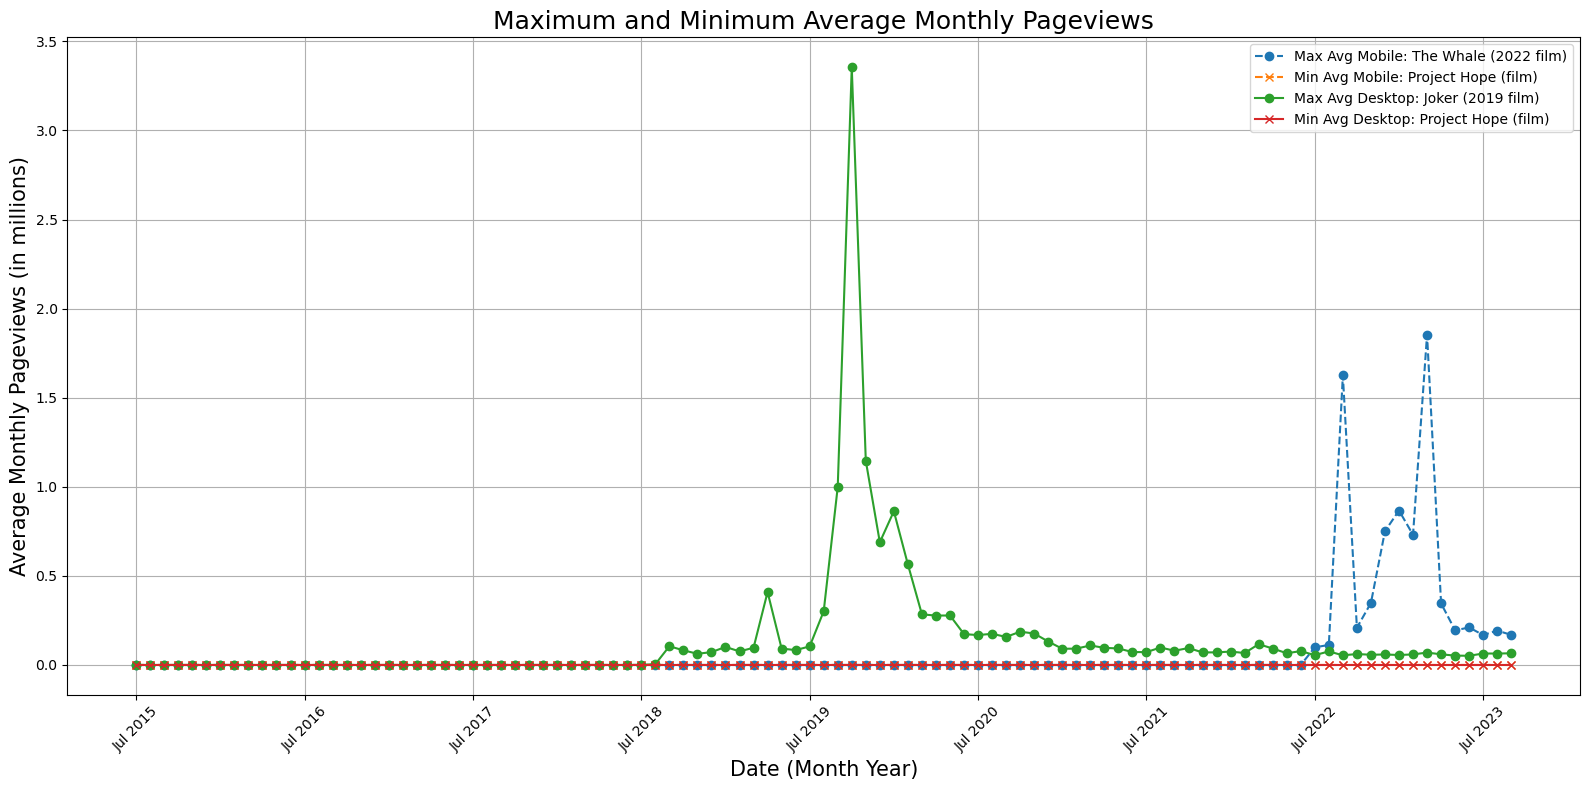

In [19]:
# average pageviews for mobile and desktop
avg_mobile_pageviews = calculate_average_pageviews(mobile_data)
avg_desktop_pageviews = calculate_average_pageviews(desktop_data)
max_avg_mobile_article = max(avg_mobile_pageviews, key=avg_mobile_pageviews.get)
min_avg_mobile_article = min(avg_mobile_pageviews, key=avg_mobile_pageviews.get)
max_avg_desktop_article = max(avg_desktop_pageviews, key=avg_desktop_pageviews.get)
min_avg_desktop_article = min(avg_desktop_pageviews, key=avg_desktop_pageviews.get)

# longest set of timestamps among the four objects
most_timestamps = find_longest_timestamps(mobile_data[max_avg_mobile_article], mobile_data[min_avg_mobile_article], desktop_data[max_avg_desktop_article], desktop_data[min_avg_desktop_article])

# align and sort  for max and min articles 
align_max_mobile = align_data_with_timestamps(mobile_data[max_avg_mobile_article], most_timestamps)
align_min_mobile = align_data_with_timestamps(mobile_data[min_avg_mobile_article], most_timestamps)
align_max_desktop = align_data_with_timestamps(desktop_data[max_avg_desktop_article], most_timestamps)
align_min_desktop = align_data_with_timestamps(desktop_data[min_avg_desktop_article], most_timestamps)

sorted_align_max_mobile = sort_data_by_timestamps(align_max_mobile)
sorted_align_min_mobile = sort_data_by_timestamps(align_min_mobile)
sorted_align_max_desktop = sort_data_by_timestamps(align_max_desktop)
sorted_align_min_desktop = sort_data_by_timestamps(align_min_desktop)

# prep data for plotting
million = 1e6
sorted_aligned_timestamps = format_timestamps(list(sorted_align_max_mobile.keys()))
sorted_max_mobile_views = np.array(list(sorted_align_max_mobile.values())) / million  # converts to millions
sorted_min_mobile_views = np.array(list(sorted_align_min_mobile.values())) / million 
sorted_max_desktop_views = np.array(list(sorted_align_max_desktop.values())) / million  
sorted_min_desktop_views = np.array(list(sorted_align_min_desktop.values())) / million  

# Plot for mobile and desktop data on the same plot
plt.figure(figsize=(16, 8))

plt.plot(sorted_aligned_timestamps, sorted_max_mobile_views, label=f"Max Avg Mobile: {max_avg_mobile_article}", linestyle='--', marker='o')
plt.plot(sorted_aligned_timestamps, sorted_min_mobile_views, label=f"Min Avg Mobile: {min_avg_mobile_article}", linestyle='--', marker='x')
plt.plot(sorted_aligned_timestamps, sorted_max_desktop_views, label=f"Max Avg Desktop: {max_avg_desktop_article}", linestyle='-', marker='o')
plt.plot(sorted_aligned_timestamps, sorted_min_desktop_views, label=f"Min Avg Desktop: {min_avg_desktop_article}", linestyle='-', marker='x')

plt.xlabel('Date (Month Year)', fontsize = 15)
plt.ylabel('Average Monthly Pageviews (in millions)', fontsize = 15)
plt.title('Maximum and Minimum Average Monthly Pageviews', fontsize = 18)
plt.xticks(sorted_aligned_timestamps[::12], rotation=45)  # one tick per year for clarity
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./results/min_max_avrg_monthy_views.png')
plt.show()



## Plot 2: Top 10 Peak Page Views
This graph contains time series for the top 10 article pages by largest (peak) page views over the entire time by access type. We first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. This section of code uses the same helper functions like `align_data_with_timestamps`, `sort_data_by_timestamps`, and `format_timestamps`. We also defined another function called `find_top_10_peak_articles`. This function just finds the 10 articles with the highest peak views.

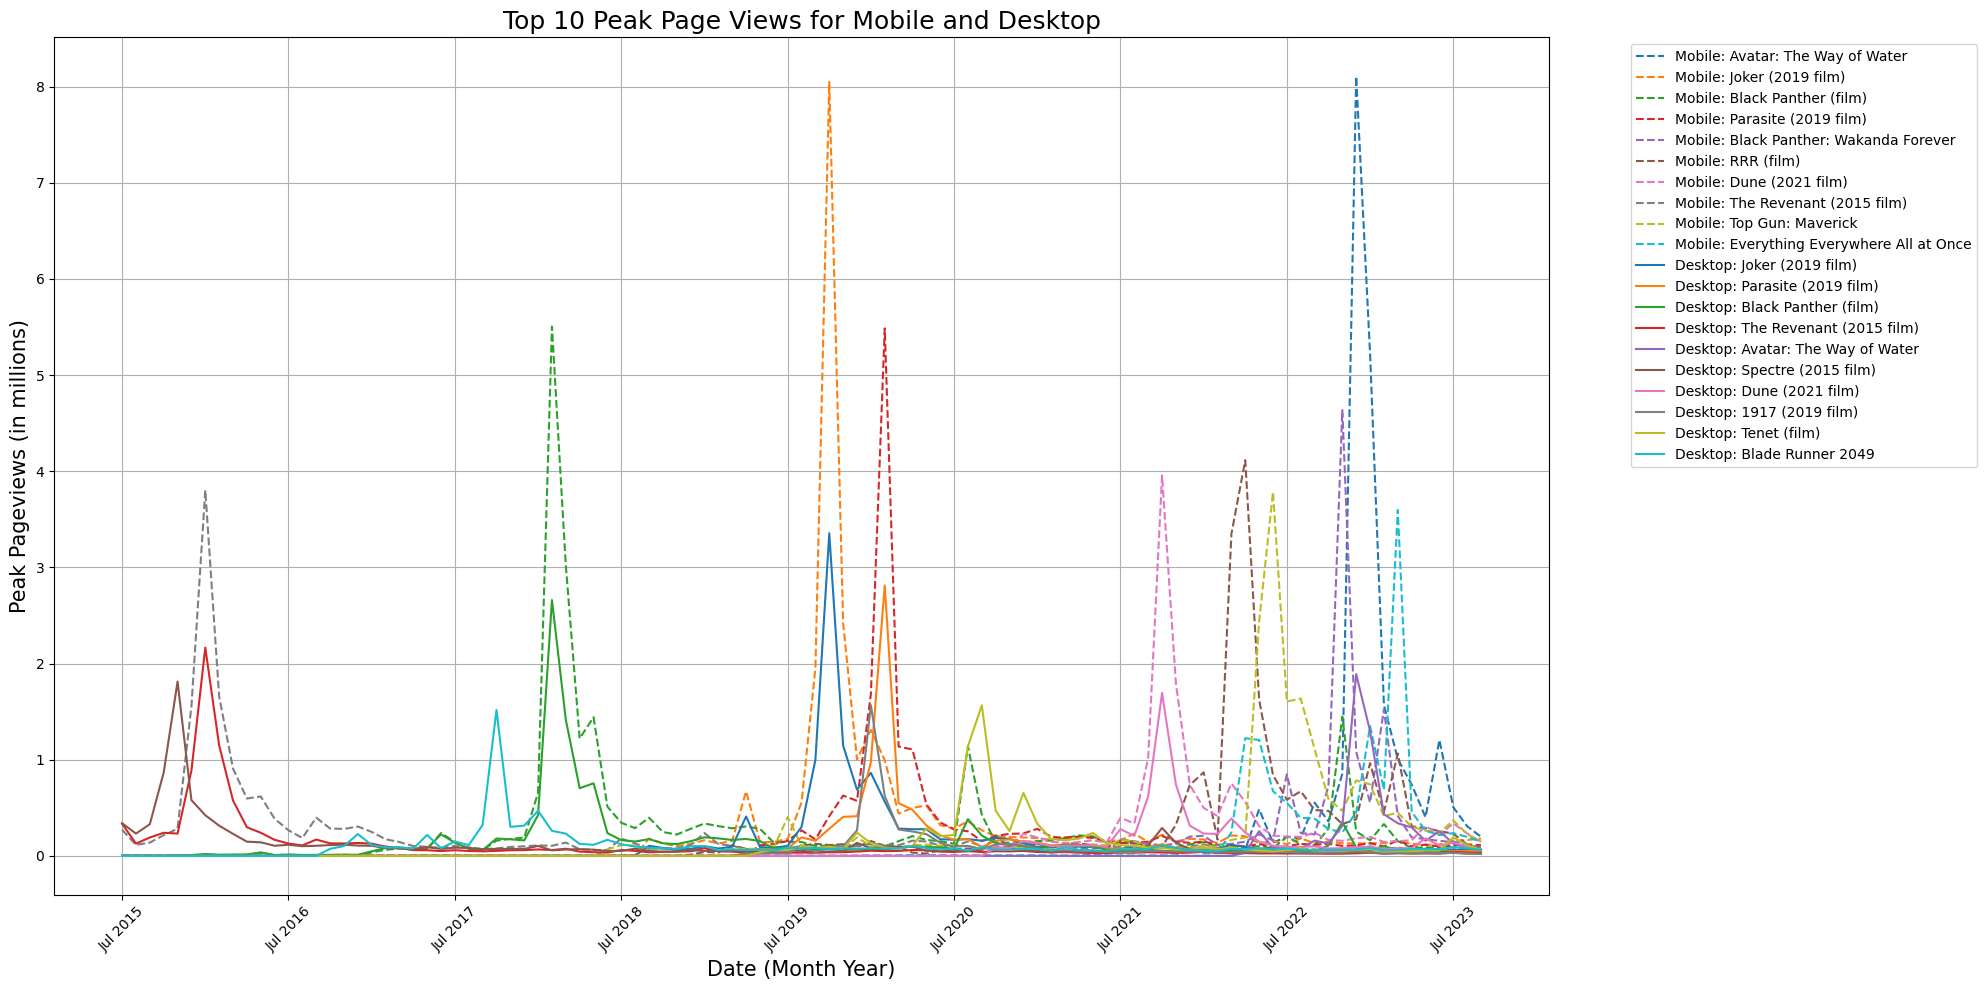

In [18]:
# find the article pages with the top 10 peak page views
def find_top_10_peak_articles(data):
    peak_views = {}
    for article, views in data.items():
        peak_views[article] = max(views.values())
    return sorted(peak_views, key=peak_views.get, reverse=True)[:10]

# top 10 articles by peak views 
top_10_peak_mobile_articles = find_top_10_peak_articles(mobile_data)
top_10_peak_desktop_articles = find_top_10_peak_articles(desktop_data)

# longest set of timestamps among the top 10 articles
longest_timestamps_top_10 = find_longest_timestamps(
    *[mobile_data[article] for article in top_10_peak_mobile_articles],
    *[desktop_data[article] for article in top_10_peak_desktop_articles]
)

# align and sort for the top 10 articles
# chat gpt helped set up this aligning code 
aligned_top_10_mobile = {article: align_data_with_timestamps(mobile_data[article], longest_timestamps_top_10) for article in top_10_peak_mobile_articles}
aligned_top_10_desktop = {article: align_data_with_timestamps(desktop_data[article], longest_timestamps_top_10) for article in top_10_peak_desktop_articles}

sorted_aligned_top_10_mobile = {article: sort_data_by_timestamps(views) for article, views in aligned_top_10_mobile.items()}
sorted_aligned_top_10_desktop = {article: sort_data_by_timestamps(views) for article, views in aligned_top_10_desktop.items()}

# prep data for plotting
sorted_aligned_timestamps_top_10 = format_timestamps(list(longest_timestamps_top_10))

plt.figure(figsize=(20, 10))

for article, views in sorted_aligned_top_10_mobile.items():
    plt.plot(sorted_aligned_timestamps_top_10, np.array(list(views.values())) / 1e6, label=f"Mobile: {article}", linestyle='--')

for article, views in sorted_aligned_top_10_desktop.items():
    plt.plot(sorted_aligned_timestamps_top_10, np.array(list(views.values())) / 1e6, label=f"Desktop: {article}", linestyle='-')

plt.xlabel('Date (Month Year)', fontsize = 15)
plt.ylabel('Peak Pageviews (in millions)', fontsize = 15)
plt.title('Top 10 Peak Page Views for Mobile and Desktop', fontsize = 18)
plt.xticks(sorted_aligned_timestamps_top_10[::12], rotation=45)  # Show one tick per year for clarity
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('./results/top_10_peak_views.png')
plt.show()


## Plot 3: Fewest Months of Data 
The third graph shows pages that have the fewest months of available data. These will all be relatively short time series and should contain a set of the most recent academy award winners. This graph shows the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

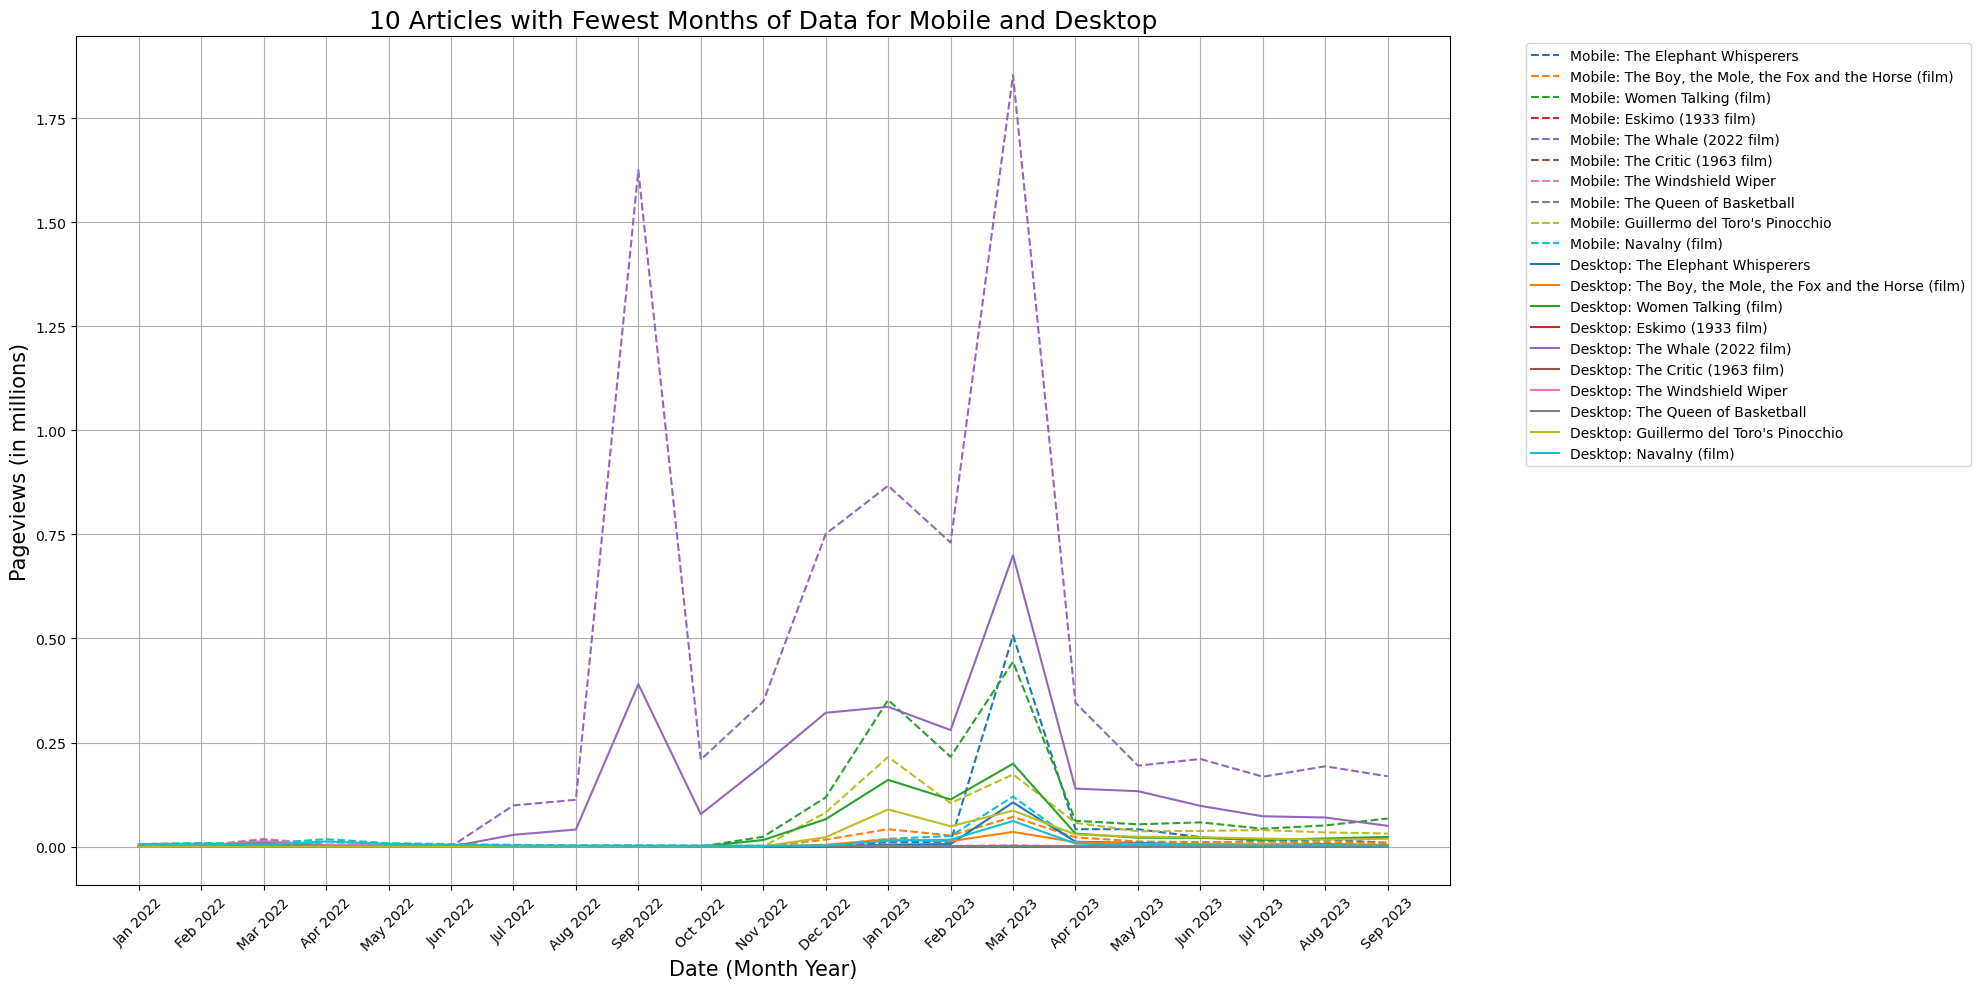

In [20]:
# find the articles with the fewest months of available data
def find_fewest_months_articles(data):
    fewest_months = {}
    for article, views in data.items():
        fewest_months[article] = len(views)
    return sorted(fewest_months, key=fewest_months.get)[:10]

# 10 articles with the least months of data
fewest_months_mobile_articles = find_fewest_months_articles(mobile_data)
fewest_months_desktop_articles = find_fewest_months_articles(desktop_data)

# longest set of timestamps among the 10 articles with fewest months 
longest_timestamps_fewest_months = find_longest_timestamps(
    *[mobile_data[article] for article in fewest_months_mobile_articles],
    *[desktop_data[article] for article in fewest_months_desktop_articles]
)

# align and sort the data for the 10 articles with fewest months
# chat gpt helped for the aligning code
aligned_fewest_months_mobile = {article: align_data_with_timestamps(mobile_data[article], longest_timestamps_fewest_months) for article in fewest_months_mobile_articles}
aligned_fewest_months_desktop = {article: align_data_with_timestamps(desktop_data[article], longest_timestamps_fewest_months) for article in fewest_months_desktop_articles}

sorted_aligned_fewest_months_mobile = {article: sort_data_by_timestamps(views) for article, views in aligned_fewest_months_mobile.items()}
sorted_aligned_fewest_months_desktop = {article: sort_data_by_timestamps(views) for article, views in aligned_fewest_months_desktop.items()}

# prep data for plotting
sorted_aligned_timestamps_fewest_months = format_timestamps(list(longest_timestamps_fewest_months))

plt.figure(figsize=(20, 10))

for article, views in sorted_aligned_fewest_months_mobile.items():
    plt.plot(sorted_aligned_timestamps_fewest_months, np.array(list(views.values())) / 1e6, label=f"Mobile: {article}", linestyle='--')

for article, views in sorted_aligned_fewest_months_desktop.items():
    plt.plot(sorted_aligned_timestamps_fewest_months, np.array(list(views.values())) / 1e6, label=f"Desktop: {article}", linestyle='-')

plt.xlabel('Date (Month Year)', fontsize = 15)
plt.ylabel('Pageviews (in millions)', fontsize = 15)
plt.title('10 Articles with Fewest Months of Data for Mobile and Desktop', fontsize = 18)
plt.xticks(sorted_aligned_timestamps_fewest_months, rotation=45)  # Show all ticks for clarity
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.savefig('./results/fewest_month_data.png')
plt.show()
